## Data

### Imports

In [84]:
import time
import os
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from gensim.models.wrappers import FastText as FastTextGM
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Activation, GlobalMaxPooling1D, Flatten
from keras.objectives import categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from bs4 import BeautifulSoup
import string
from nltk.probability import FreqDist
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  
from gensim.models.fasttext import FastText
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from ipywidgets import IntProgress
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None 
output_notebook()
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
class_type_encoding = {0: 'HQ', 1: 'LQ_CLOSE', 2: 'LQ_EDIT'}

### Loading data

Подключимся с помощью GoogleDrive, чтобы в последствии хранить там все результаты и модели

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
sample_size = int(input("What sample size will you analyze (max 48000)? "))

What sample size will you analyze (max 48000)? 48000


In [88]:
train_raw = pd.read_parquet("/content/drive/MyDrive/NLP/train.parquet")
test_raw = pd.read_parquet("/content/drive/MyDrive/NLP/test.parquet")

In [ ]:
train_raw = train_raw.reset_index().drop(['Id'], axis=1)
test_raw = test_raw.reset_index().drop(['Id'], axis=1)

In [89]:
train_raw.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


## EDA

### Preprocessing

Процедуры предобработки и создания новых фич, из интересных реализован определение частей речи с помощью возможностей nltk.

In [76]:
def preprocess_sentence(text):
    soup = BeautifulSoup(text, "lxml")
    text = soup.get_text()

    text = ''.join([sym for sym in text if sym not in (string.punctuation + string.digits)])
    text = text.lower().strip()

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    word_tokens = word_tokenize(text)
    filtered_sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words])
    return filtered_sentence

In [77]:
def preprocessing(data):
  data['Tags'] = data.Tags.apply(lambda x: x.replace('<', '').replace('>', ' ').strip())

  data['Text'] = data.Title + " " + data.Body
  data['Text'] = data.Text.apply(preprocess_sentence)

  data.drop(columns=['Body', 'Title'], inplace=True)
  return data

In [ ]:
def create_new_features(df):
  # Number of words in the text 
  df["count_words"] = df.Text.apply(lambda x: len(x.split()))
  # Number of unique words in the text 
  df["count_unique_word"] = df.Text.apply(lambda x: len(set(x.split())))
  # Number of stopwords in the text 
  df["count_stopwords"] = df.Text.apply(lambda x: len([word for word in x.split() if word in STOPWORDS]))
  # Average length of the words in the text 
  df["mean_word_len"] = df.Text.apply(lambda x: np.mean([len(word) for word in x.split()]))
  # Number of tags
  df["count_tags"] = df.Tags.apply(lambda x: len(x.split()))
  # Number of tags in the text, how much it matches the given theme
  df["number_tags_in_text"] = [len(set(df.Tags[i].split()) & set(df.Text[i].split())) for i in range(len(df))]
  # Percent of noun in the text
  df["percent_noun"] = df.Text.apply(lambda x: len([word for word in x.split() if nltk.pos_tag([word])[0][1] == 'NN'])/len(x.split()))
  # Percent of verb in the text
  df["percent_verb"] = df.Text.apply(lambda x: len([word for word in x.split() if nltk.pos_tag([word])[0][1] == 'VB'])/len(x.split()))
  # Percent of adjective in the text
  df["percent_adj"] = df.Text.apply(lambda x: len([word for word in x.split() if nltk.pos_tag([word])[0][1] == 'JJ'])/len(x.split()))
  return df

In [90]:
def preparation_data(data):
  data = preprocessing(data)
  #data = create_new_features(data)
  print(f'В данных {data.isna().sum().sum()} пустых данных. Добавлены новые столбцы теперь их {len(data.columns)}.')
  return data

Сохраним полученные данные, чтоб в последствии не ждать, а использовать уже готовое

In [91]:
preprocessed_train = preparation_data(train_raw)
preprocessed_test = preparation_data(test_raw)
preprocessed_train.to_csv('/content/drive/MyDrive/NLP/processed_train_final.csv', index=False)
preprocessed_test.to_csv('/content/drive/MyDrive/NLP/processed_test_final.csv', index=False)

В данных 0 пустных данных. Добавлены новые столбцы теперь их 3.
В данных 0 пустных данных. Добавлены новые столбцы теперь их 2.


### Сharts and graph

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP/processed_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP/processed_test.csv")

In [ ]:
df_train.head()

,Tags,target,Text,count_words,count_unique_word,count_stopwords,mean_word_len,count_tags,number_tags_in_text,percent_noun,percent_verb,percent_adj
0,java algorithm graph-algorithm,2,implementing minimum spanning forrest algorihm...,62,45,0,4.709677,3,1,0.774194,0.048387,0.032258
1,html r dataframe,2,r studio date getting converted number making ...,19,13,1,5.736842,3,2,0.578947,0.052632,0.000000
2,python pandas dataframe pandas-groupby,0,panda dataframe groupby get sum multiple colum...,95,52,6,4.431579,4,1,0.747368,0.031579,0.021053
3,angular typescript rxjs,0,casting result observableforkjoin respective t...,110,73,3,8.936364,3,2,0.627273,0.045455,0.045455
4,c windows batch-file,1,environment variable set batch file accessed c...,26,19,0,5.576923,3,1,0.615385,0.000000,0.115385


In [ ]:
df_train['target'].value_counts()

2    16000
1    16000
0    16000
Name: target, dtype: int64

Целевая переменная распределена равномерно

In [ ]:
def most_popular_tags_by_class(df, class_number):
  all_tags_list = [tag for tags in df.Tags.loc[df.target == class_number] for tag in tags.split(' ')]
  count_tags = Counter(all_tags_list)
  count_tags_df = pd.DataFrame(count_tags.most_common(15))
  count_tags_df.columns = ['word','count']
  return count_tags_df


def color_change(df):
  color_df = df.apply(lambda x: 'purple' if x>1000 else 'blue')
  return list(color_df)

def plot_subplot_popular_tags(df):
  count_class = df['target'].nunique()
  fig, axs = plt.subplots(3, 1, figsize=(count_class*5, count_class*4))
  for class_type in range(count_class):
    df_tags = most_popular_tags_by_class(df, class_type)
    axs[class_type].bar(df_tags['word'], df_tags['count'], color=color_change(df_tags['count']))
    axs[class_type].set_ylabel('Count')
    axs[class_type].set_title(f'Most common words in class {class_type_encoding.get(class_type)}')
  plt.show()

График наиболее популярных тегов, распределенный по целевой переменной и выделены все теги с частотой больше 1000

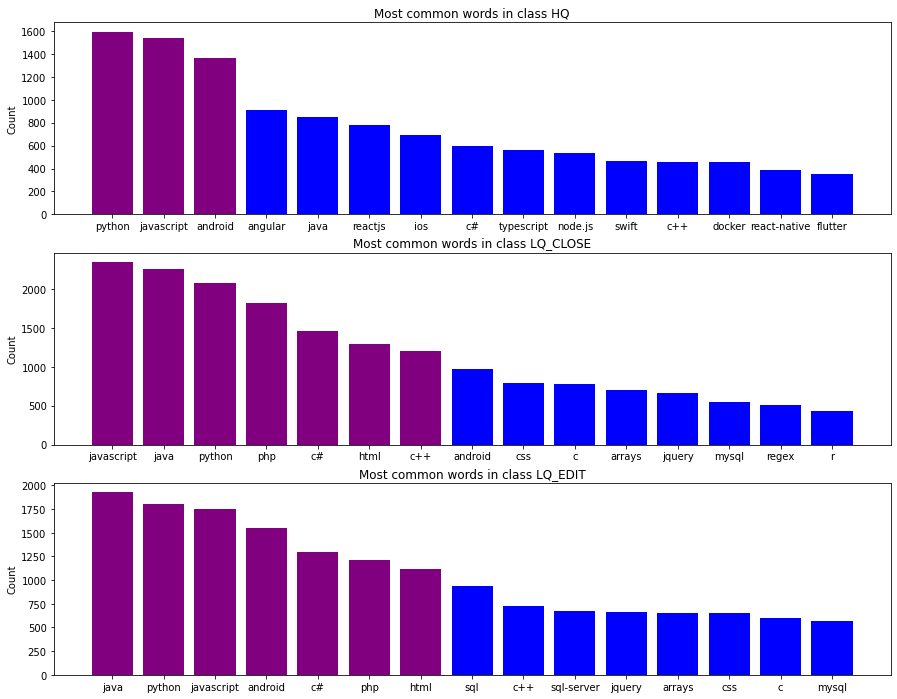

In [ ]:
plot_subplot_popular_tags(df_train)

Исходя из этих графиков можно сказать, что хоть классы и разные, самые популярные теги в них повторяются. Единственное в HQ более выражены лидеры, а в LQ распределение более плавное

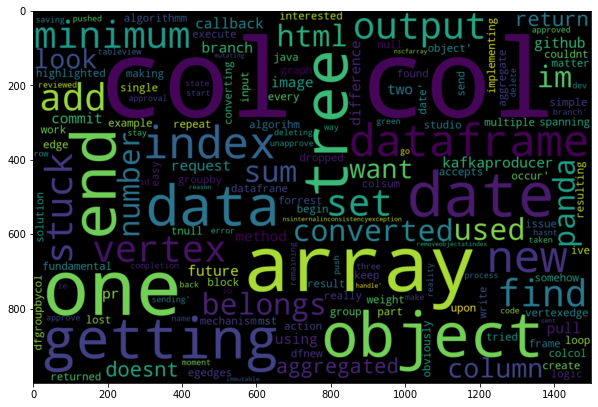

In [ ]:
wordcloud = WordCloud(max_words=800, width=1500, height=1000).generate(str(df_train.Text.values))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')

Облако слов, построенное на данных из текста, ожидалось, что самыми встречающимися словами буду различные зарегистрированные слова в языках, которые чаще всего встречались в тегах, но получилось что это слова из часто используемых технологий в данных языках.


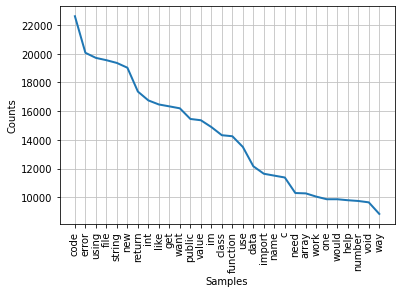

In [ ]:
text = df_train['Text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(text)
word_dist = nltk.FreqDist(words)
word_dist.plot(30, cumulative=False)

Слова из текста но уже с распределением по количеству. Не удивительно самое популярные слова: code и error, куда же без нее, когда сайт создан для помощи исправления ОШИБОК в КОДЕ.

Попробуем изобразить с помощью кластеризации наши классы, используя только новосозданные фичи.

In [ ]:
train_without_text = df_train.copy()
train_without_text.drop(columns=['Text', 'Tags'], inplace=True)
train_Y_without_text = train_without_text['target']
train_X_without_text = train_without_text.drop('target', axis=1)

In [ ]:
pca = PCA(n_components=2)
pca.fit(train_X_without_text)
train_X_pca_without_text = pca.transform(train_X_without_text)

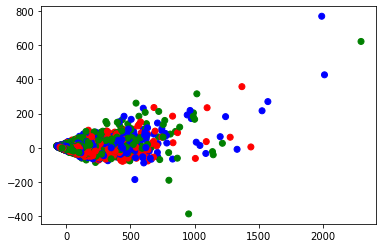

In [ ]:
colors = {0: 'r', 1: 'b', 2: 'g'}
plt.scatter(train_X_pca_without_text[:,0], train_X_pca_without_text[:,1], color=train_Y_without_text.map(colors))

Как можно заметить каких либо сформировавшихся групп нет, а значит только числовые параметры не дают адекватных результатов. Нужно конечно же использовать анализ текста

## Embeddings


### Preparation full data

In [18]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP/processed_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP/processed_test.csv")

In [19]:
df_train = df_train[:sample_size]
df_test = df_test[:sample_size//5]

In [20]:
train = df_train[['Text', 'Tags', 'target']]
test = df_test[['Text', 'Tags']]
train['Text'] = df_train['Text'] + " " + df_train['Tags']
test['Text'] = df_test['Text'] + " " + df_test['Tags']
train = train.drop(['Tags'], axis=1)
test = test.drop(['Tags'], axis=1)
full_data = pd.concat([train, test], ignore_index=True)
train.head()

,Text,target
0,implementing minimum spanning forrest algorihm...,2
1,r studio date getting converted number making ...,2
2,panda dataframe groupby get sum multiple colum...,0
3,casting result observableforkjoin respective t...,0
4,environment variable set batch file accessed c...,1


Теперь создадим вектора, используя различные методы

### OneHotEncoding

In [21]:
vectorizer = CountVectorizer()
one_hot_vectorized = vectorizer.fit_transform(train.Text)

### TF-IDF

In [22]:
tf_idf = TfidfVectorizer()
train_tf_idf_vectors = tf_idf.fit_transform(train.Text) 

### FastText

#### Functions

In [23]:
def get_fasttext_vectors(corpus, model):    
    
    def get_vector(sentence):   
        vector = 0
        for w in sentence:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

#### Pretrained

Используется модель с [официального сайта](https://fasttext.cc/docs/en/english-vectors.html). Для исправления ошибки с переполнением RAM будем удалять модель после использования.

In [24]:
pretrained_fasttext = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP/models/wiki-news-300d-1M.vec")

In [25]:
train_fasttext_vectors = get_fasttext_vectors(train.Text, pretrained_fasttext)
del pretrained_fasttext

#### Our own

In [26]:
own_fasttext = FastText(size=300)
fasttext_sentence = full_data.Text
own_fasttext.build_vocab(sentences=fasttext_sentence)
own_fasttext.train(sentences=fasttext_sentence, 
                          epochs=own_fasttext.epochs,
                          total_examples=own_fasttext.corpus_count, 
                          total_words=own_fasttext.corpus_total_words)
print(own_fasttext)

FastText(vocab=256, size=300, alpha=0.025)


In [27]:
train_own_fasttext_vectors = get_fasttext_vectors(train.Text, own_fasttext)
del own_fasttext

### Word2Vec

#### Functions

In [28]:
def word2vec_sentence(df, model):
  list_word2vec = []
  for index, row in pd.DataFrame(df).iterrows():
     model_vector = (np.mean([model[token] for token in row['Text']], axis=0)).tolist()
     list_word2vec.append(model_vector)
  return np.array(list_word2vec)

In [29]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=500, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [30]:
w2v_full_data = train.Text.apply(lambda x: x.split())

#### Pretrained

In [10]:
pretrained_word2vec = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP/models/GoogleNews-vectors-negative300.bin", binary=True)

In [11]:
pretrained_word2vec.most_similar("code")

[('codes', 0.7752988338470459),
 ('Code', 0.5879452228546143),
 ('Codes', 0.548393189907074),
 ('Java_byte', 0.5327669382095337),
 ('refactored', 0.5249555110931396),
 ('coding', 0.51395183801651),
 ('decompiled', 0.5040692090988159),
 ('Ltd._TTI_HKEx', 0.5028575658798218),
 ('Java_bytecode', 0.5027563571929932),
 ('GCC_compiler', 0.49278783798217773)]

Почему-то эта модель не имеет большей части слов, изза чего вектора обрезались и было принято решение отказаться от нее, в угоду другим методам.

In [12]:
del pretrained_word2vec

In [62]:
#word2vec = word2vec_sentence(w2v_full_data, pretrained_word2vec)

In [63]:
#word2vec.shape

#### Our oun


In [55]:
W2V_FILENAME = "/content/drive/MyDrive/NLP/saved_models/my_word2vec.model"
w2v_model = Word2Vec(sentences=w2v_full_data, size=100, window=5, min_count=1, workers=4).wv
w2v_model.save(W2V_FILENAME)

In [32]:
w2v_model.most_similar("code")

[('snippet', 0.8343947529792786),
 ('here', 0.8127659559249878),
 ('part', 0.8069972991943359),
 ('properly', 0.8048858046531677),
 ('instead', 0.7829577922821045),
 ('correctly', 0.7792267203330994),
 ('piece', 0.7774677872657776),
 ('wrote', 0.7701422572135925),
 ('program', 0.7566112279891968),
 ('problem', 0.7552000880241394)]

Создадим визуализацию embeddings с помощью bohen

In [33]:
words = sorted(w2v_model.vocab.keys(), 
               key=lambda word: w2v_model.vocab[word].count,
               reverse=True)[:1000]
word2vec_vectors = np.array([w2v_model.get_vector(vector) for vector in words])

In [34]:
pca = PCA(n_components=2)
pca.fit(word2vec_vectors)
word_vectors_pca = pca.transform(word2vec_vectors)
word_vectors_pca = (word_vectors_pca - word_vectors_pca.mean(axis=0)) / word_vectors_pca.std(axis=0)

In [35]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1002', ...)

Анализируя, получилось найти довольно большое количество зависимостей, которые показывают, что модели строятся вполне логично, а именно:

*   В верхней правой области вместе расположились названия функций, которые склеились в целиковые слова. Хоть они совсем и разные по смыслу модель определила их вместе
*   Аналогично модель поступила и с тегами html, которые сгруппировались справа посередине.
*   Довольно интересно ушли в сторону override, void, int, которые точно встречаются часто, но видимо из-за того что это объявление функций и обычно вокруг них куча символов или склеившиеся названия функция, они отошли в сторонку. Аналогичная ситуация со словами project, app, service. Так что популярные слова, не обязательно в центре основного ядра.
* Из интересного внутри: aws (amazon web service), находится рядом с reactjs, connect, request. Что в большей части имеет логику; Близко находятся week, minute, time; и т.д

Все это доказывает неплохое построение модели.




In [36]:
my_word2vec = word2vec_sentence(w2v_full_data, w2v_model)
del w2v_model

## ML Models

Сразу понимаю, как долго будет все это считаться, то, что придется ставить ночью и это может вылететь. Было принято решение написать "архитектуру", которая автоматически сохраняет при подсчете любую модель в таблички csv, хранящиеся на гугл диске. Также это позволяет параллельно тестировать на разных объемах, так как всегда создаются разные таблицы. Нам кажется что это дало нам уверенности, что можно спать и на утро у нас не сгорит ****.

Примерно вот так все это выглядело в конце экспериментов:

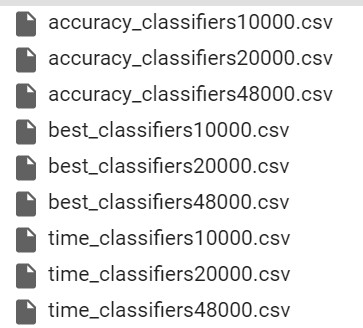


Функции загрузки и выгрузки на гугл диск

In [39]:
RESULT_DIR = "/content/drive/MyDrive/NLP/result/"
def dict_to_csv(best_classifiers, time_list, accuracy_classifier, sample_size):
  pd.DataFrame(best_classifiers).to_csv(RESULT_DIR+f"best_classifiers{sample_size}.csv")
  pd.DataFrame(time_list).to_csv(RESULT_DIR+f"time_classifiers{sample_size}.csv")
  pd.DataFrame(accuracy_classifier).to_csv(RESULT_DIR+f"accuracy_classifiers{sample_size}.csv")

def read_all_csv(sample_size):
  best_classifiers = dict(zip(classifiers, [dict(zip(list_embeddings, [None for lt in list_embeddings])) for cl in classifiers]))
  accuracy_classifier = dict(zip(classifiers, [dict(zip(list_embeddings, [None for lt in list_embeddings])) for cl in classifiers]))
  time_list = dict(zip(classifiers, [dict(zip(list_embeddings, [None for lt in list_embeddings])) for cl in classifiers]))
  return best_classifiers, accuracy_classifier, time_list

Проходка по словарям и замена значений

In [40]:
def dict_iteration(diction, best_classifiers, accuracy_classifier, time_list, value):
  for clf_name, clf in diction.items():
    for emb_name in diction[clf_name]:
      best_classifiers[clf_name][emb_name] = value
      time_list[clf_name][emb_name] = value
      accuracy_classifier[clf_name][emb_name] = value 
  return best_classifiers, accuracy_classifier, time_list

Все embeddings после сплита

In [41]:
y = train['target']

embeddings = {'OneHotEncoding': (train_test_split(one_hot_vectorized, y, test_size=0.2, random_state=42)),
              'tf_idf': (train_test_split(train_tf_idf_vectors, y, test_size=0.2, random_state=42)),
              'own_word2vec': (train_test_split(my_word2vec, y, test_size=0.2, random_state=42)),
              'pretrained_fasttext': (train_test_split(train_fasttext_vectors, y, test_size=0.2, random_state=42)),
              'own_fasttext': (train_test_split(train_own_fasttext_vectors, y, test_size=0.2, random_state=42)),} 

Классификаторы и подбираемые в дальнейшем гиперпараметры, а также словари с данными для удаления (чтоб пересчитать), и блокируемые данные, которые считаются годами

In [42]:
classifiers = {'KNN': KNeighborsClassifier(),
               'SVM': SVC(),
               'DecisionTree': DecisionTreeClassifier(),
               'RandomForest': RandomForestClassifier(),
               'Adaboost': AdaBoostClassifier(),
               'XGBoost': XGBClassifier()}

parameters = {'KNN': {'n_neighbors' : np.arange(3, 20, 2),
                       'weights' : ['uniform', 'distance'],
                       'p' : [1, 2]},
              'SVM': {'kernel' : ['linear', 'poly', 'sigmoid'],
                      'random_state' : [42]},
              'DecisionTree': {'max_depth': np.arange(2, 20, 2),
                               'random_state': [42],
                               'max_features': ['auto', 'sqrt', 'log2']},
              'RandomForest': {'max_depth': np.arange(2, 20, 2),
                               'random_state': [42]},
              'Adaboost': {'base_estimator': [RandomForestClassifier(max_depth=10), DecisionTreeClassifier(max_depth=10)],
                           'n_estimators': [100, 500],
                           'random_state': [42]},
              'XGBoost': {'max_depth':[1, 5], 
                          'learning_rate':[0.1, 1], 
                          'n_estimators':[10, 100],
                          'random_state': [42]}}

error_models_dict = {'SVM': ['pretrained_fasttext', 'own_fasttext'],}

list_embeddings = list(embeddings.keys())

action = "add"

dict_of_deleting = {'Adaboost': list_embeddings, }

In [ ]:
if not os.path.exists(RESULT_DIR+f"best_classifiers{sample_size}.csv"):
  best_classifiers, accuracy_classifier, time_list = read_all_csv(sample_size)
elif action == "delete":
  best_classifiers, accuracy_classifier, time_list = read_all_csv(sample_size)
  best_classifiers, accuracy_classifier, time_list = dict_iteration(dict_of_deleting, best_classifiers, accuracy_classifier, time_list, None)
elif action == "add":
  classifiers_df, accuracy_df, time_df = read_all_csv(sample_size)
  for classifier in classifiers:
    best_classifiers = dict(zip(classifiers, [dict(zip(list_embeddings, list(classifiers_df[classifier]))) for classifier in classifiers]))
    accuracy_classifier = dict(zip(classifiers, [dict(zip(list_embeddings, list(accuracy_df[classifier]))) for classifier in classifiers]))
    time_list = dict(zip(classifiers, [dict(zip(list_embeddings, list(time_df[classifier]))) for classifier in classifiers]))
dict_to_csv(best_classifiers, time_list, accuracy_classifier, sample_size)

In [41]:
for clf_name, clf in classifiers.items():
  for emb_name, embedding in embeddings.items():
    if best_classifiers[clf_name][emb_name] == -1:
      best_classifiers[clf_name][emb_name] = None
      time_list[clf_name][emb_name] = None
      accuracy_classifier[clf_name][emb_name] = None
best_classifiers, accuracy_classifier, time_list = dict_iteration(error_models_dict, best_classifiers, accuracy_classifier, time_list, -1)
dict_to_csv(best_classifiers, time_list, accuracy_classifier, sample_size)

Основной код с небольшой визуализацией прошедшего процесса, чтоб можно было встать в 4 утра и понять насколько все плохо

In [ ]:
progress_clf = IntProgress(min=0, max=len(classifiers))
progress_clf.value = 0
progress_emb = IntProgress(min=0, max=len(embeddings))
progress_emb.value = 0
display(progress_clf)
display(progress_emb)
for clf_name, clf in classifiers.items():
  progress_clf.description = clf_name
  for emb_name, embedding in embeddings.items():
    if best_classifiers[clf_name][emb_name] is None or pd.isnull(best_classifiers[clf_name][emb_name]):
      progress_emb.description = emb_name
      start_time = time.time()
      best_clf = GridSearchCV(clf, param_grid=parameters[clf_name])
      best_clf.fit(embedding[0], embedding[2])

      best_classifiers[clf_name][emb_name] = best_clf
      time_list[clf_name][emb_name] = time.time() - start_time
      accuracy_classifier[clf_name][emb_name] = accuracy_score(embedding[3], best_clf.predict(embedding[1]))
      dict_to_csv(best_classifiers, time_list, accuracy_classifier, sample_size)
    progress_emb.value += 1
  progress_emb.value = 0
  progress_clf.value += 1

## Neural network

Была создана полносвязная нейронная сеть.

In [ ]:
X = train.Text.values
Y = train.target.values

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

count_words = embeddings['tf_idf'][0].shape[1]

tokenizer = Tokenizer(num_words=count_words)
tokenizer.fit_on_texts(X_train_raw)

X_train = tokenizer.texts_to_sequences(X_train_raw)
X_test = tokenizer.texts_to_sequences(X_test_raw)

X_train = pad_sequences(X_train, padding='post', maxlen=200)
X_test = pad_sequences(X_test, padding='post', maxlen=200)

Y_train = to_categorical(Y_train, 3)
Y_test = to_categorical(Y_test, 3)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=count_words, output_dim=300, input_length=200))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='sigmoid'))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.fit(X_train, Y_train, epochs=10, verbose=True, validation_data=(X_test, Y_test), batch_size=128)

Epoch 1/10
300/300 [==============================] - 420s 1s/step - loss: 0.8394 - accuracy: 0.5641 - val_loss: 0.7317 - val_accuracy: 0.6496
Epoch 2/10
300/300 [==============================] - 414s 1s/step - loss: 0.6220 - accuracy: 0.7138 - val_loss: 0.7333 - val_accuracy: 0.6665
Epoch 3/10
300/300 [==============================] - 414s 1s/step - loss: 0.4388 - accuracy: 0.8179 - val_loss: 0.8218 - val_accuracy: 0.6529
Epoch 4/10
300/300 [==============================] - 422s 1s/step - loss: 0.2753 - accuracy: 0.8930 - val_loss: 1.0142 - val_accuracy: 0.6373
Epoch 5/10
300/300 [==============================] - 416s 1s/step - loss: 0.1599 - accuracy: 0.9412 - val_loss: 1.2093 - val_accuracy: 0.6361
Epoch 6/10
300/300 [==============================] - 418s 1s/step - loss: 0.0916 - accuracy: 0.9669 - val_loss: 1.4567 - val_accuracy: 0.6264
Epoch 7/10
300/300 [==============================] - 417s 1s/step - loss: 0.0537 - accuracy: 0.9812 - val_loss: 1.8228 - val_accuracy: 0.6292

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9950
Testing Accuracy: 0.6070


Мы подбирали какое количество скрытых слоев, и с каким изменением величины сетки лучше всего подходит для этих данных. И почему то здесь не работалос "чем больше, тем лучше". Оптимальным оказалась представленная модель, единственное она начинает переобучаться после 2 эпохе. Именно в этот момент наименьшее расстояние между точностью валидационно и тестируемой.

## ИТОГИ И ВЫВОДЫ

Проанализируем данные 10000 и 48000, так как промежуточные 20к почти не отличаются от 10к, только считались дольше, и небольшой прирост точности в некоторых методах.

In [51]:
accuracy_10000 = pd.read_csv(RESULT_DIR+f"accuracy_classifiers10000.csv")
accuracy_48000 = pd.read_csv(RESULT_DIR+f"accuracy_classifiers48000.csv")
time_10000 = pd.read_csv(RESULT_DIR+f"time_classifiers10000.csv")

In [49]:
accuracy_10000

,Unnamed: 0,KNN,SVM,DecisionTree,RandomForest,Adaboost,XGBoost
0,OneHotEncoding,0.4570,0.6045,0.4335,0.6170,0.6405,0.6365
1,tf_idf,0.5830,0.6565,0.3965,0.6080,0.6505,0.6310
2,own_word2vec,0.5810,0.5955,0.5280,0.5895,0.6110,0.6140
3,pretrained_fasttext,0.4470,-1.0000,0.4275,0.4855,0.4735,0.4830
4,own_fasttext,0.4365,-1.0000,0.4330,0.4815,0.4805,0.4850


In [50]:
accuracy_48000

,Unnamed: 0,KNN,SVM,DecisionTree,RandomForest,Adaboost,XGBoost
0,OneHotEncoding,0.473125,-1,0.395833,0.615729,-1,-1
1,tf_idf,0.584896,-1,0.393750,0.613854,-1,-1
2,own_word2vec,0.618125,-1,0.547083,0.630208,-1,-1
3,pretrained_fasttext,0.442708,-1,0.431146,0.466667,-1,-1
4,own_fasttext,0.446146,-1,0.431667,0.470729,-1,-1


Для полноты картины добавим время подсчета для 10к, для 48к пропорционально дольше в экспоненциальной (геометрической, или какой то еще прогрессии), в общем очень долго

In [52]:
time_10000

,Unnamed: 0,KNN,SVM,DecisionTree,RandomForest,Adaboost,XGBoost
0,OneHotEncoding,454.905654,311.109279,5.253603,75.998464,4610.062262,649.760697
1,tf_idf,451.285936,316.001148,3.743269,77.160382,4908.235129,747.281651
2,own_word2vec,338.170762,90.731942,6.556751,143.372739,8021.187110,310.124990
3,pretrained_fasttext,243.173603,-1.000000,10.573518,247.435415,7812.007800,873.947500
4,own_fasttext,338.361952,-1.000000,10.595346,243.290683,5981.552705,812.249974


Adaboost и XGBoost, вместе с нейросетью показывают хорошие результаты, но посчитать их на 48к абсолютно нереально, на adaboost на 20к один единственный метод считается от 5 до 8 часов. Поэтому будем искать метод идеальный по соотношению качество/время. И по нашему мнению таким является RandomForest на любой из первых 3 embeddings. Кстати такой факт, что fasttext везде показал себя просто ужасно. Если хочется посчитать моментально не не важна точность, то выбор определенно DecisionTree, на нем мы проверяли работу кода, так как подождать его намного проще, чем даже примитивные методы.

Поэтому вывод: для определения финальных результатов будем использовать RandomForest с собственным word2vec (не зря ж его создавали), к тому же по графикам мы сами видели хорошие зависимости.

In [113]:
train = preprocessed_train
test = preprocessed_test
full_data = pd.concat([train, test])
full_data.head()

,Tags,target,Text
Id,,,
34862324,java algorithm graph-algorithm,2.0,implementing minimum spanning forrest algorihm...
47303682,html r dataframe,2.0,r studio date getting converted number making ...
46431243,python pandas dataframe pandas-groupby,0.0,panda dataframe groupby get sum multiple colum...
45306324,angular typescript rxjs,0.0,casting result observableforkjoin respective t...
49479547,c windows batch-file,1.0,environment variable set batch file accessed c...


In [115]:
w2v_full_data = full_data.Text.apply(lambda x: x.split())
w2v_train_data = train.Text.apply(lambda x: x.split())
w2v_test_data = test.Text.apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=w2v_full_data, size=100, window=5, min_count=1, workers=4).wv
X_train = word2vec_sentence(w2v_train_data, w2v_model)
X_test = word2vec_sentence(w2v_test_data, w2v_model)
Y_train = train['target']
del w2v_model

In [124]:
best_clf = GridSearchCV(RandomForestClassifier(), param_grid=parameters['RandomForest'])
best_clf.fit(X_train, Y_train)
prediction = best_clf.predict(X_test)

In [134]:
test_answer = test.copy()
test_answer['Predicted'] = prediction
test_answer = test_answer.drop(['Tags', 'Text'], axis=1)
test_answer.to_csv("/content/drive/MyDrive/NLP/test.csv")
test_answer.head()

,Predicted
Id,
46785369,0
38908667,0
44703012,0
34910435,0
51632121,1


ЛАБА ОГОНЬ: интересно, но дооооооооооооооооооооооооооооооооолго